In [ ]:
## Installing the Packages needed for training the model.
!--upgrade pip
!pip install tensorflow
!pip install --upgrade pandas
!pip install matplotlib
!pip install --upgrade numpy
!pip install seaborn

# Importing the needed Libraries for the training

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from PIL import Image




# Creating a Pandas Dataframe that has a Path and Label for each image

In [3]:
#create an empty DataFrame
column_names=['path','label']
df = pd.DataFrame(columns=column_names,dtype=object)

#loop over fire images and label them 1
for dirname, _, filenames in os.walk('fire_dataset/fire_images'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))

#loop over non fire images and label them 0
for dirname, _, filenames in os.walk('fire_dataset/non_fire_images'):
    for filename in filenames:
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))
        #print(os.path.join(dirname, filename))

#shuffle the dataset for redistribute the labels
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

path     label
0         fire_dataset/fire_images/fire.74.png      fire
1         fire_dataset/fire_images/fire.25.png      fire
2        fire_dataset/fire_images/fire.579.png      fire
3          fire_dataset/fire_images/fire.8.png      fire
4  fire_dataset/non_fire_images/non_fire.5.png  non_fire
5        fire_dataset/fire_images/fire.194.png      fire
6        fire_dataset/fire_images/fire.182.png      fire
7        fire_dataset/fire_images/fire.433.png      fire
8        fire_dataset/fire_images/fire.417.png      fire
9        fire_dataset/fire_images/fire.668.png      fire

In [ ]:
fig = px.scatter(data_frame = df,x=df.index,y='label',color='label',title='Distribution of fire and non-fire images along the length of the dataframe')
fig.update_traces(marker_size=2)

In [ ]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "pie"}]])


fig.add_trace(go.Bar(x =df['label'].value_counts().index,y=df['label'].value_counts().to_numpy(),marker_color=['darkorange','green'],showlegend=False),row=1,col=1)

fig.add_trace(go.Pie(
     values=df['label'].value_counts().to_numpy(),
     labels=df['label'].value_counts().index,
    marker=dict(colors=['darkorange','green'])),
    row=1, col=2)

In [ ]:
label = 'fire' #label for images with fire
data = df[df['label'] == label]
sns.set_style('dark')


pics = 6 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Images with Fire')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

In [ ]:
label = 'non_fire' #label for images without fire
data = df[df['label'] == label]
sns.set_style('dark')


pics = 6 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Images with Fire')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

In [4]:
def shaper(row):
    shape = image.load_img(row['path']).size
    row['height'] = shape[1]
    row['width'] = shape[0]
    return row
df = df.apply(shaper,axis=1)
df.head(5)

path     label  height  width
0         fire_dataset/fire_images/fire.74.png      fire     399    665
1         fire_dataset/fire_images/fire.25.png      fire     399    600
2        fire_dataset/fire_images/fire.579.png      fire     366    650
3          fire_dataset/fire_images/fire.8.png      fire    1080   1920
4  fire_dataset/non_fire_images/non_fire.5.png  non_fire     332    590

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:693: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


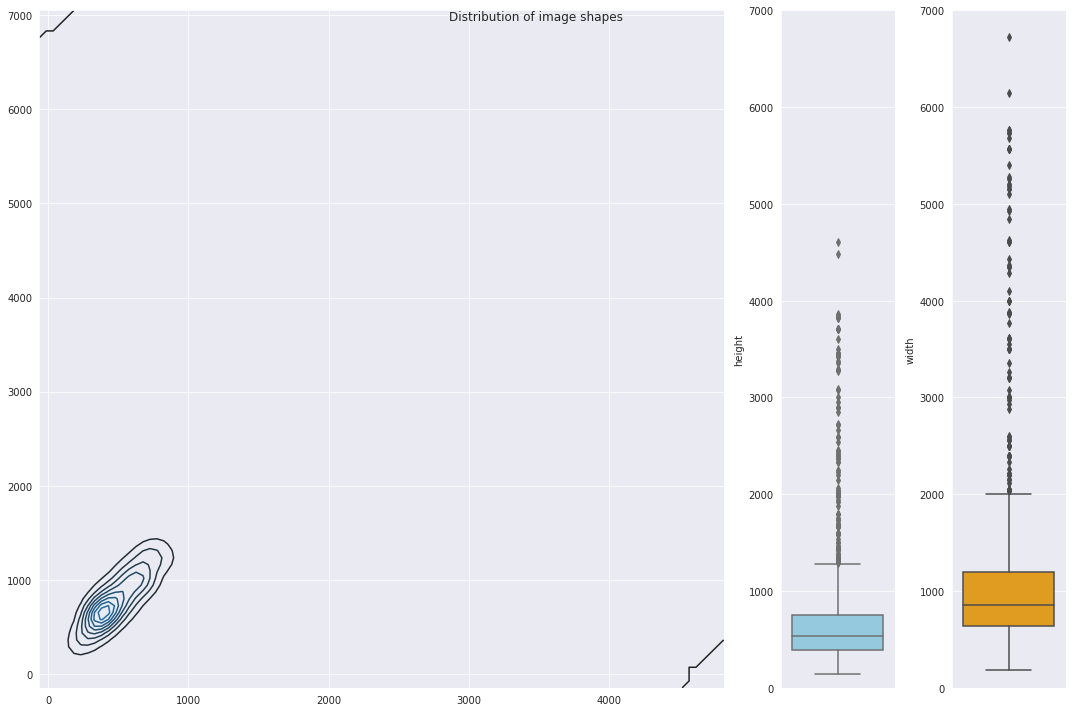

In [6]:
sns.set_style('darkgrid')
fig,(ax1,ax2,ax3) = plt.subplots(1,3,gridspec_kw={'width_ratios': [3,0.5,0.5]},figsize=(15,10))
sns.kdeplot(data=df.drop(columns=['path','label']),ax=ax1,legend=True)
sns.boxplot(data=df,y='height',ax=ax2,color='skyblue')
sns.boxplot(data=df,y='width',ax=ax3,color='orange')
plt.suptitle('Distribution of image shapes')
ax3.set_ylim(0,7000)
ax2.set_ylim(0,7000)
plt.tight_layout()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
generator = ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1/255,
    validation_split=0.2,
)

In [9]:
train_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='training')
val_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='validation')

Found 800 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


In [10]:
class_indices = {}
for key in train_gen.class_indices.keys():
    class_indices[train_gen.class_indices[key]] = key
    
print(class_indices)

{0: 'fire', 1: 'non_fire'}


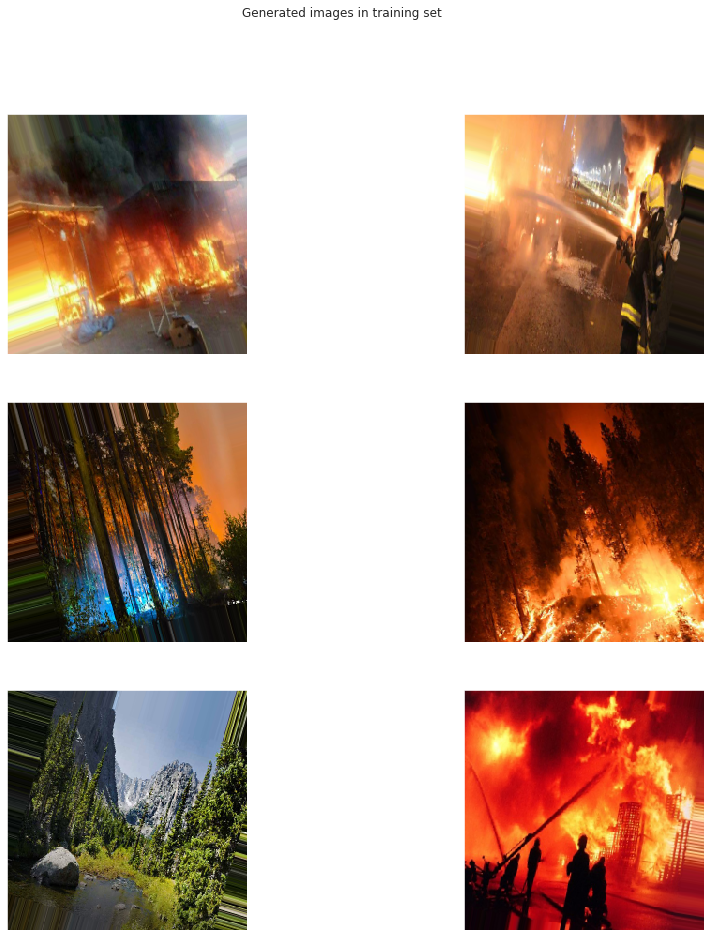

In [11]:
sns.set_style('dark')
pics = 6 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Generated images in training set')
ax = ax.ravel()
for i in range((pics//2)*2):
    ax[i].imshow(train_gen[0][0][i])
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [13]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size = (2,2),activation='relu',input_shape = (256,256,3)))
model.add(MaxPool2D())
model.add(Conv2D(filters=64,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(filters=128,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 128)      0

In [15]:
from tensorflow.keras.metrics import Recall,AUC
from tensorflow.keras.utils import plot_model

In [16]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',Recall(),AUC()])

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [18]:
early_stoppping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5)

In [19]:
model.fit(x=train_gen,batch_size=32,epochs=5,validation_data=val_gen,callbacks=[early_stoppping,reduce_lr_on_plateau])

Epoch 1/5
25/25 [==============================] - 105s 4s/step - loss: 0.3183 - accuracy: 0.8450 - recall: 0.6771 - auc: 0.9082 - val_loss: 0.1543 - val_accuracy: 0.9397 - val_recall: 0.9615 - val_auc: 0.9914 - lr: 0.0010
Epoch 2/5
25/25 [==============================] - 102s 4s/step - loss: 0.1471 - accuracy: 0.9488 - recall: 0.8854 - auc: 0.9812 - val_loss: 0.1401 - val_accuracy: 0.9598 - val_recall: 0.8654 - val_auc: 0.9804 - lr: 0.0010
Epoch 3/5
25/25 [==============================] - 101s 4s/step - loss: 0.1054 - accuracy: 0.9550 - recall: 0.8750 - auc: 0.9908 - val_loss: 0.1004 - val_accuracy: 0.9698 - val_recall: 0.9423 - val_auc: 0.9913 - lr: 0.0010
Epoch 4/5
25/25 [==============================] - 102s 4s/step - loss: 0.0896 - accuracy: 0.9688 - recall: 0.9375 - auc: 0.9933 - val_loss: 0.2329 - val_accuracy: 0.9447 - val_recall: 0.7885 - val_auc: 0.9689 - lr: 0.0010
Epoch 5/5
25/25 [==============================] - 102s 4s/step - loss: 0.1182 - accuracy: 0.9650 - recall: 

In [20]:
history= model.history.history
px.line(history,title = "Metrics Plot")

In [21]:
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

7/7 [==============================] - 12s 2s/step - loss: 0.0958 - accuracy: 0.9749 - recall: 0.9038 - auc: 0.9927
loss: 0.10
accuracy: 0.97
recall: 0.90
auc: 0.99


In [22]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout

In [23]:
xception = Xception(include_top = False,input_shape = (256,256,3))
input_to_model = xception.input
#turn off training
xception.trainable = False

x = Flatten()(xception.output)
x = Dense(64,activation = 'relu')(x)
output_to_model = Dense(1,activation = 'sigmoid')(x)
model2 = Model(inputs = input_to_model,outputs = output_to_model)

83697664/83683744 [==============================] - 2s 0us/step


In [24]:
model2.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy',Recall(),AUC()])

In [25]:
history2 = model2.fit(x = train_gen,batch_size=32,epochs=3,callbacks = [early_stoppping,reduce_lr_on_plateau],validation_data = val_gen)

Epoch 1/3
25/25 [==============================] - 216s 9s/step - loss: 1.6919 - accuracy: 0.8550 - recall_1: 0.6198 - auc_1: 0.8626 - val_loss: 0.2179 - val_accuracy: 0.9598 - val_recall_1: 1.0000 - val_auc_1: 0.9911 - lr: 0.0010
Epoch 2/3
25/25 [==============================] - 209s 8s/step - loss: 0.1356 - accuracy: 0.9625 - recall_1: 0.9219 - auc_1: 0.9866 - val_loss: 0.0793 - val_accuracy: 0.9648 - val_recall_1: 0.9038 - val_auc_1: 0.9954 - lr: 0.0010
Epoch 3/3
25/25 [==============================] - 210s 8s/step - loss: 0.0880 - accuracy: 0.9737 - recall_1: 0.9375 - auc_1: 0.9938 - val_loss: 0.1050 - val_accuracy: 0.9548 - val_recall_1: 0.8462 - val_auc_1: 0.9920 - lr: 0.0010


In [26]:
px.line(history,title='Metrics Plot')

In [27]:
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

7/7 [==============================] - 12s 2s/step - loss: 0.1100 - accuracy: 0.9648 - recall: 0.8654 - auc: 0.9895
loss: 0.11
accuracy: 0.96
recall: 0.87
auc: 0.99


In [28]:
#Downloading the image
!curl https://static01.nyt.com/images/2021/02/19/world/19storm-briefing-texas-fire/19storm-briefing-texas-fire-articleLarge.jpg --output predict.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50241  100 50241    0     0   114k      0 --:--:-- --:--:-- --:--:--  114k


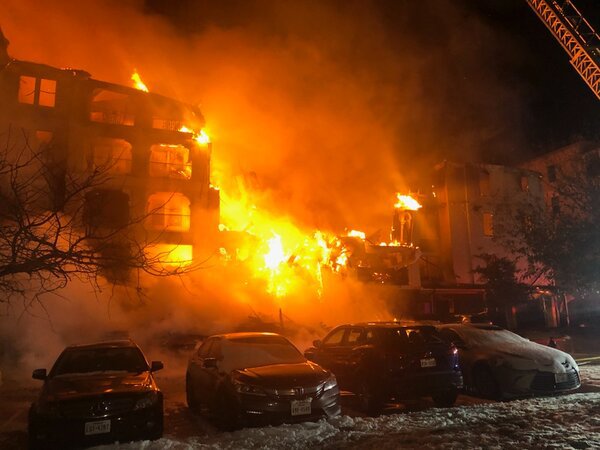

In [29]:
#loading the image
img = image.load_img('predict.jpg')
img

In [30]:
img = image.img_to_array(img)/255
img = tf.image.resize(img,(256,256))
img = tf.expand_dims(img,axis=0)

print("Image Shape",img.shape)

Image Shape (1, 256, 256, 3)


In [31]:
prediction = int(tf.round(model2.predict(x=img)).numpy()[0][0])
print("The predicted value is: ",prediction,"and the predicted label is:",class_indices[prediction])

The predicted value is:  0 and the predicted label is: fire


In [32]:
tf.saved_model.save(model2, 'saved_model')

INFO:tensorflow:Assets written to: saved_model/assets


In [33]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model') # path to the SavedModel directory
tflite_model = converter.convert()


In [34]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)